<a href="https://colab.research.google.com/github/ScottHay14/Natural-Language-Processing-Coursework/blob/main/Natural_Language_Processing_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative AI was used to support completion of this assessment. ChatGPT was used for the purpose of ideation. It was used to give some ideas of different algorithms I could use those being the Linear Support Vector Machine and Multinomial Naive Bayes

## Section 1 - Dataset

The Drug Reviews dataset from Druglib.com is a collection of patient reviews on specific drugs along with the related conditions. The dataset is broken up into these 9 variables and has around 4000 reviews.
<br>
<br>reviewID
<br>urlDrugName
<br>rating
<br>effectiveness
<br>sideEffects
<br>condition
<br>benefitsReview
<br>sideEffectsReview
<br>commentsReview
<br>
<br>
The task going to be performed in my classwork is text classification with the goal of predicting drug effectievness ratings from the patients reviews. The effectiveness variable is categorical and contains 5 options of effectiveness, these being Highly Effective, Considerably Effective, Moderately Effective, Marginally Effective and Ineffective.



In [181]:
# Google Colab deletes the folder and need to have the Data folder with the dataset. Running this gets it from the github and copies Data folder to /content/Data
!git clone https://github.com/ScottHay14/Natural-Language-Processing-Coursework
!cp -r /content/Natural-Language-Processing-Coursework/Data /content/Data

fatal: destination path 'Natural-Language-Processing-Coursework' already exists and is not an empty directory.


In [182]:
# Imports
import pandas as pd
import numpy as np

In [183]:
# Loading Data and combining the test and train dataset into one dataframe
test_data = "/content/Data/drugLibTest_raw.tsv"
train_data = "/content/Data/drugLibTrain_raw.tsv"

test_df = pd.read_csv(test_data, delimiter="\t")
train_df = pd.read_csv(train_data, delimiter="\t")

df = pd.concat([test_df, train_df], ignore_index=True)

In [184]:
# Exploring Data
print(df.head()) # Just printing first rows to see if loaded correctly

print("\nClass distribution")
print(df["effectiveness"].value_counts()) # Shows a large class imbalance



   Unnamed: 0 urlDrugName  rating           effectiveness  \
0        1366      biaxin       9  Considerably Effective   
1        3724    lamictal       9        Highly Effective   
2        3824    depakene       4    Moderately Effective   
3         969     sarafem      10        Highly Effective   
4         696    accutane      10        Highly Effective   

           sideEffects           condition  \
0    Mild Side Effects     sinus infection   
1    Mild Side Effects    bipolar disorder   
2  Severe Side Effects    bipolar disorder   
3      No Side Effects  bi-polar / anxiety   
4    Mild Side Effects        nodular acne   

                                      benefitsReview  \
0  The antibiotic may have destroyed bacteria cau...   
1  Lamictal stabilized my serious mood swings. On...   
2  Initial benefits were comparable to the brand ...   
3  It controlls my mood swings. It helps me think...   
4  Within one week of treatment superficial acne ...   

                   

In [185]:
# Combining the 3 review categories into one (benefitsReview, sideEffectsReview, commentsReview) for both the training dataset and the testing dataset

# Train dataset combined first
train_df["combined_review"] = train_df["benefitsReview"].astype(str) + "\n\n" + train_df["sideEffectsReview"].astype(str) + "\n\n" +  train_df["commentsReview"].astype(str)
x_train = train_df["combined_review"].to_numpy()
y_train = train_df["effectiveness"].to_numpy()
print("Train dataset example")
print(x_train[0][:1000])
print(y_train[0])
print("\n")

# Test dataset combined after
test_df["combined_review"] = test_df["benefitsReview"].astype(str) + "\n\n" + test_df["sideEffectsReview"].astype(str) + "\n\n" +  test_df["commentsReview"].astype(str)
x_test = test_df["combined_review"].to_numpy()
y_test = test_df["effectiveness"].to_numpy()
print("Test dataset example")
print(x_test[0][:1000])
print(y_test[0])

Train dataset example


mangagement of congestive heart failur

cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness

monitor blood pressure , weight and asses for resolution of fluid
Highly Effective


Test dataset example
The antibiotic may have destroyed bacteria causing my sinus infection.  But it may also have been caused by a virus, so its hard to say.

Some back pain, some nauseau.

Took the antibiotics for 14 days. Sinus infection was gone after the 6th day.
Considerably Effective


In [186]:
# Preprocessing data
import nltk

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

def prep(X):
  prep_text = []
  for x in X:
    token_text = word_tokenize(x)
    normd_text = [token.lower() for token in token_text if token.isalpha()]
    swr_text = [token for token in normd_text if token not in stopwords.words("english")]
    stemmer = SnowballStemmer("english")
    prep_text += [[stemmer.stem(word) for word in swr_text]]
  prep_sentences = [" ".join(sentence) for sentence in prep_text]
  return prep_sentences

prep_x_train = prep(x_train)
prep_x_test = prep(x_test)

print("Preprocessed working for train dataset")
print(prep_x_train[0][:1000])

print("Preprocessed working for test dataset")
print(prep_x_test[0][:1000])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed working for train dataset
slow progress left ventricular dysfunct overt heart failur alon agent manag hypertens mangag congest heart failur cough hypotens proteinuria impot renal failur angina pectori tachycardia eosinophil pneumon tast disturb anuseas anorecia weak fatigu insominca weak monitor blood pressur weight ass resolut fluid
Preprocessed working for test dataset
antibiot may destroy bacteria caus sinus infect may also caus virus hard say back pain nauseau took antibiot day sinus infect gone day


## Section 2 - Representation Learning

Term frequency-inverse document frequency (tf-idf) is a way to measure the importance of a word within a document or a collection of documents also known as a corpus. For the drug dataset the document would be the combined review. TF has a formula of

TF(t,d) = Number of times term t appears in document d / Total number of terms in document
So if the word "slowed" for example appeared once and the combined review had a total of 75 words TF=1/75=0.013
The next part is IDF which will measure how rare a word is across a corpus. It has the formula

IDF(t,d) = log(Total number of doucments in the corpus N / Number of documents containing term t)
So for a common word like drug it would have a lower idf.

The final part is just multiplying so TF-IDF = TF * IDF this results in words getting a higher TF-IDF if it appears a lot in this context a review but is not common in the corpus.

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [188]:
# Representation Learning - TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf.fit_transform(prep_x_train)
x_test_tfidf = tfidf.transform(prep_x_test)

# Data Exploration
feature_names = tfidf.get_feature_names_out()
print(f"Sample {list(feature_names)[:15]}")


Sample ['aarp', 'abait', 'abandon', 'abat', 'abbout', 'abbsess', 'abcess', 'abdo', 'abdomen', 'abdomin', 'aberr', 'abfter', 'abil', 'abilifi', 'abit']


## Section 3 - Algorithms

## Linear Support Vector Machine
Linear Support Vector Machine is an algorithm used for classification and regression tasks. How SVM works is it finds a boundary known as a hyperplane that best separates the data into the different classes. SVM works best for binary classifiers, but it can also work for multi-class classification.

Support vectors are data points that are closest to the hyperplane these define the class boundary. The distance from these datapoints to the hyperplane is called the margin. The main idea of SVM is to maximise this margin, as a larger margin makes the model more confident and more accurate for predicting new data.
A soft margin can also be tweaked because you cannot always separate classes perfectly from each other, so this makes some of the data be misclassified.
There is a parameter called C this lets you tweak the strictness of the margins, so if the C value was high, it would be stricter but if lowered, it would allow more misclassifications.

## Multinomial Naive Bayes
Multinomial Navie Bayes is a variation based on the Navie Bayes algorithm and is commonly used for text classification. The "naive" part means that everything is seen as independent from each other, so each word in a sentence is treated individually. How it works is it gets the frequency of words in a document and then starts to estimate how likely a word would appear in a document for each class.

For example, for my dataset the classes are the effectiveness of the drugs, so the 5 classes are highly effective, considerably effective, etc. Then let's say the word "works" is very frequent in the combined reviews for the highly effective class the model would start to learn that the word is strongly associated with the highly effective class. So when it moves on to a new review, the Multinomial Navie Bayes would calculate what class it is in based on each individual word and try to predict the class with the highest probability.

In [189]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize score lists for multiple metrics
svm_acc_scores = []
svm_f1_macro_scores = []
mnb_acc_scores = []
mnb_f1_macro_scores = []

kf = StratifiedKFold(n_splits=10, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(prep_x_train, y_train_encoded), 1):
    print(f"\nFold {fold}/10")

    x_train_fold = [prep_x_train[i] for i in train_idx]
    x_val_fold = [prep_x_train[i] for i in val_idx]
    y_train_fold = y_train_encoded[train_idx]
    y_val_fold = y_train_encoded[val_idx]

    tfidf_fold = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.90,
        sublinear_tf=False
    )

    x_train_tfidf = tfidf_fold.fit_transform(x_train_fold)
    x_val_tfidf = tfidf_fold.transform(x_val_fold)

    svm = LinearSVC(
        class_weight="balanced", # balanced mode uses value of y to adjust weights
        max_iter=1000,
        C=1.0
    )

    svm.fit(x_train_tfidf, y_train_fold)
    svm_pred = svm.predict(x_val_tfidf)

    svm_acc = accuracy_score(y_val_fold, svm_pred)
    svm_f1_macro = f1_score(y_val_fold, svm_pred, average='macro')

    svm_acc_scores.append(svm_acc)
    svm_f1_macro_scores.append(svm_f1_macro)

    print(f"  LinearSVC Accuracy: {svm_acc:.4f}, F1-macro: {svm_f1_macro:.4f}")

    mnb = MultinomialNB(alpha=1.0)
    mnb.fit(x_train_tfidf, y_train_fold)
    mnb_pred = mnb.predict(x_val_tfidf)

    mnb_acc = accuracy_score(y_val_fold, mnb_pred)
    mnb_f1_macro = f1_score(y_val_fold, mnb_pred, average='macro')

    mnb_acc_scores.append(mnb_acc)
    mnb_f1_macro_scores.append(mnb_f1_macro)

    print(f"  MultinomialNB Accuracy: {mnb_acc:.4f}, F1-macro: {mnb_f1_macro:.4f}")





Fold 1/10
  LinearSVC Accuracy: 0.4534, F1-macro: 0.3406
  MultinomialNB Accuracy: 0.4405, F1-macro: 0.1472

Fold 2/10
  LinearSVC Accuracy: 0.4791, F1-macro: 0.3967
  MultinomialNB Accuracy: 0.4469, F1-macro: 0.1594

Fold 3/10
  LinearSVC Accuracy: 0.4405, F1-macro: 0.3312
  MultinomialNB Accuracy: 0.4598, F1-macro: 0.1664

Fold 4/10
  LinearSVC Accuracy: 0.4437, F1-macro: 0.3362
  MultinomialNB Accuracy: 0.4469, F1-macro: 0.1665

Fold 5/10
  LinearSVC Accuracy: 0.4405, F1-macro: 0.3471
  MultinomialNB Accuracy: 0.4277, F1-macro: 0.1443

Fold 6/10
  LinearSVC Accuracy: 0.4952, F1-macro: 0.3926
  MultinomialNB Accuracy: 0.4341, F1-macro: 0.1482

Fold 7/10
  LinearSVC Accuracy: 0.4116, F1-macro: 0.3500
  MultinomialNB Accuracy: 0.4341, F1-macro: 0.1482

Fold 8/10
  LinearSVC Accuracy: 0.4742, F1-macro: 0.3886
  MultinomialNB Accuracy: 0.4484, F1-macro: 0.1600

Fold 9/10
  LinearSVC Accuracy: 0.4742, F1-macro: 0.3644
  MultinomialNB Accuracy: 0.4484, F1-macro: 0.1573

Fold 10/10
  Linea

## Section 4 - Evaluation

Text(0.5, 0.98, 'Algorithm Performance')

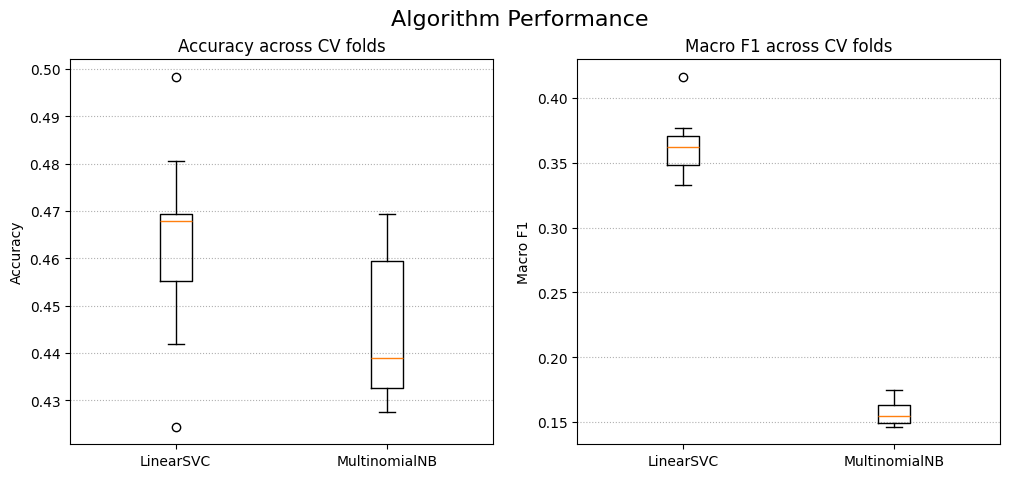

In [190]:
import matplotlib.pyplot as plt

# Accuracy scoring for the two algorithms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].boxplot(acc_data, tick_labels=model_order)
axes[0].set_title("Accuracy across CV folds")
axes[0].set_ylabel("Accuracy")
axes[0].grid(axis="y", linestyle=":")

# Macro Scoring for the two algorithms
axes[1].boxplot(f1_data, tick_labels=model_order)
axes[1].set_title("Macro F1 across CV folds")
axes[1].set_ylabel("Macro F1")
axes[1].grid(axis="y", linestyle=":")

fig.suptitle("Algorithm Performance", fontsize=16)


Displaying the results shows that the Linear SVC performs much better than the Multinomial Naive Bayes, both in accuracy and in the macro F1 score. The multinomiaNB does very poorly when it comes to F1 score this very low F1 score is due to the large class imbalance. A way to increase the accuracy would probably be to merge or have more distinct classes, as it is hard for the models to distinguish between a highly effective document and a considerably effective one.

Another algorithm that could have performed better is the random forest and also saw that XGBoost can be good for multi-class classification.

## References
GeeksforGeeks (2021). Support Vector Machine (SVM) Algorithm. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/machine-learning/support-vector-machine-algorithm/.

‌GeeksforGeeks (2023). Multinomial Naive Bayes. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/machine-learning/multinomial-naive-bayes/.

‌Scikit-learn (2019). sklearn.naive_bayes.MultinomialNB — scikit-learn 0.22 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html.

‌scikit-learn. (2025). LinearSVC. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#gallery-examples [Accessed 26 Nov. 2025].

‌